In [41]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, ConvLSTM1D

In [2]:
# Load the dataset
data = pd.read_csv('data/data_imputed.csv')

# Drop unnecessary columns
data = data.drop(['timestamp_local', 'city_name', 'country_code'], axis=1)

In [3]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [62]:
# Define window size for sequence data
window_size = 720

In [63]:
# Prepare data for LSTM
X, y = [], []
for i in range(len(data) - window_size):
    X.append(scaled_data[i:i + window_size])
    y.append(scaled_data[i + window_size])

X, y = np.array(X), np.array(y)

In [64]:
# Split the data into train and test sets
train_size = int(0.8 * len(data))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

In [65]:
# Define and compile the LSTM model
model = Sequential([
    Input(shape = (window_size, X_train.shape[2])),
    LSTM(128, return_sequences=True),
    LSTM(128, return_sequences=False),
    # ConvLSTM1D(50, return_sequences=False, kernel_size=8),
    Dense(64),
    # LSTM(50, return_sequences=False),
    Dense(8)  # 8 output features
])
model.compile(optimizer='adam', loss='mean_squared_error')

In [66]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                       │ (None, 720, 128)            │          70,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_30 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 210,504 (822.28 KB)

 Trainable params: 210,504 (822.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the LSTM model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, shuffle=False)

Epoch 1/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 415s 1s/step - loss: 0.0131 - val_loss: 0.0021
Epoch 2/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 487s 1s/step - loss: 0.0059 - val_loss: 0.0019
Epoch 3/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - loss: 0.0048 - val_loss: 0.0014
Epoch 4/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 524s 1s/step - loss: 0.0039 - val_loss: 0.0012
Epoch 5/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 544s 1s/step - loss: 0.0032 - val_loss: 9.2749e-04
Epoch 6/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 529s 1s/step - loss: 0.0028 - val_loss: 7.7097e-04
Epoch 7/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 522s 1s/step - loss: 0.0024 - val_loss: 6.4696e-04
Epoch 8/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 511s 1s/step - loss: 0.0019 - val_loss: 5.7425e-04
Epoch 9/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - loss: 0.0016 - val_loss: 4.7779e-04
Epoch 10/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - loss: 0.0015 - val_loss: 4.3274e-04
Epoch 11/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - loss: 0.0013 - val_loss: 3.8573e-04
Ep

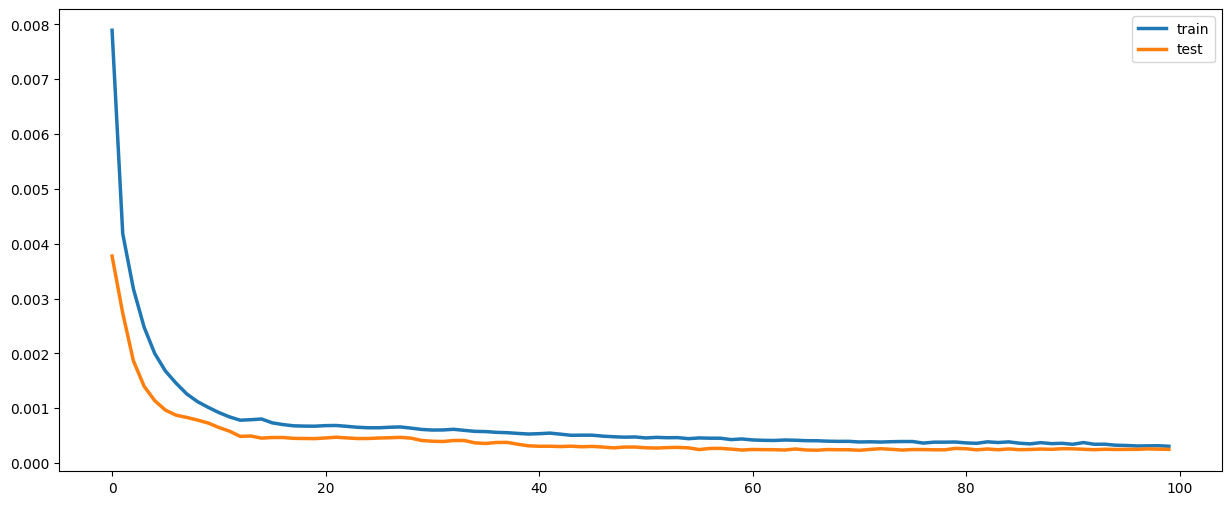

In [58]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [59]:
# Forecasting
predictions = model.predict(X_test)

114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [60]:
from sklearn.metrics import mean_squared_error
# Invert scaling for true values
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 8))

# Invert scaling for predicted values
predictions_original = scaler.inverse_transform(predictions.reshape(-1, 8))

# Calculate RMSE after inverting scaling
rmse_original = np.sqrt(mean_squared_error(y_test_original, predictions_original))
print("Root Mean Squared Error (RMSE) after inverting scaling:", rmse_original)

Root Mean Squared Error (RMSE) after inverting scaling: 29.56417274199787


In [61]:
# Extract only the first column (temperature) for true values and predicted values
y_test_temperature = y_test_original[:, 0]
predictions_temperature = predictions_original[:, 0]

# Calculate RMSE for temperature only
rmse_temperature = np.sqrt(mean_squared_error(y_test_temperature, predictions_temperature))
print("Root Mean Squared Error (RMSE) for temperature:", rmse_temperature)

Root Mean Squared Error (RMSE) for temperature: 2.302953750285404


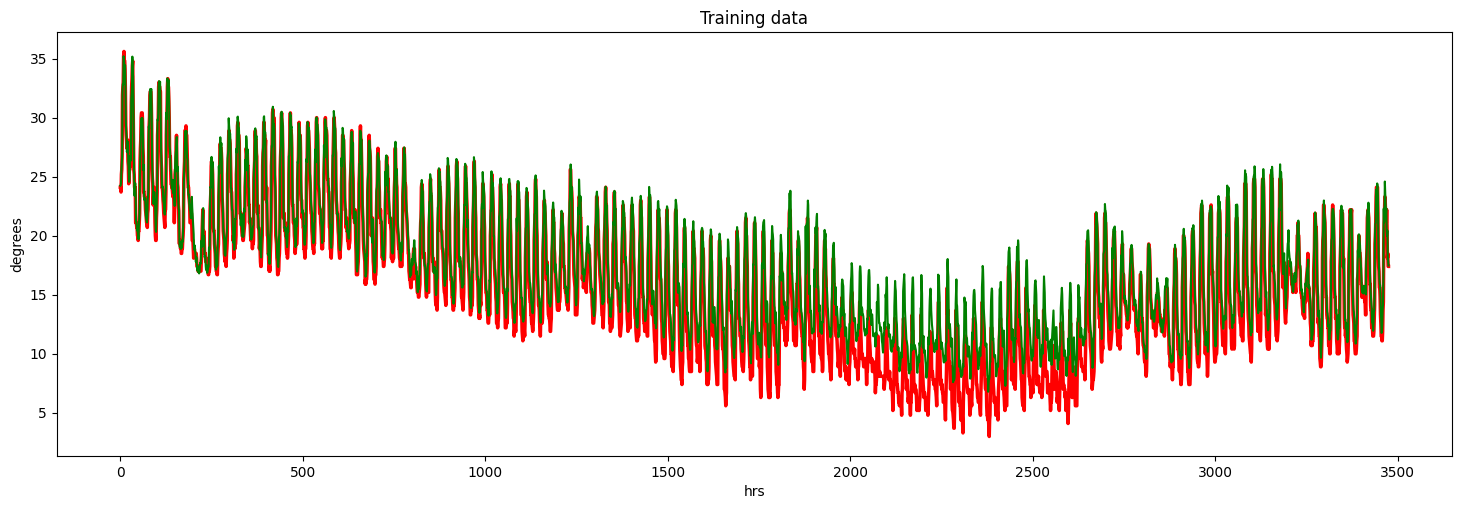

In [13]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,5.5))
plt.ylabel("degrees")
plt.xlabel("hrs")
plt.plot(y_test_temperature, c = "red", linewidth = 2.5)
plt.plot(predictions_temperature, c = "green")
plt.title("Training data")
plt.show()

In [14]:
# Extract only the first column (temperature) for true values and predicted values
y_test_aqi = y_test_original[:, 1]
predictions_aqi = predictions_original[:, 1]

# Calculate RMSE for temperature only
rmse_aqi = np.sqrt(mean_squared_error(y_test_aqi, predictions_aqi))
print("Root Mean Squared Error (RMSE) for temperature:", rmse_aqi)

Root Mean Squared Error (RMSE) for temperature: 16.73974476371177


In [4]:
# Number of future time steps to forecast
num_steps = 10  # For example, forecast the next 10 time steps

# Copy the last window_size data points from the test set
future_input = X_test[-1]

# Create an empty list to store future predictions
future_predictions = []

# Forecast future data points
for i in range(num_steps):
    # Reshape the input for prediction
    future_input_reshaped = future_input.reshape((1, window_size, X_test.shape[2]))
    
    # Make prediction
    future_prediction = model.predict(future_input_reshaped)
    
    # Append the prediction to the list of future predictions
    future_predictions.append(future_prediction)
    
    # Update input data for the next prediction
    future_input = np.append(future_input[1:], future_prediction, axis=0)

# Convert the list of future predictions to numpy array
future_predictions = np.array(future_predictions)

# Rescale the future predictions to the original scale
future_predictions_rescaled = scaler.inverse_transform(future_predictions.reshape(-1, 8))

# Print the forecasted future data
print("Forecasted Future Data:")
print(future_predictions_rescaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Forecasted Future Data:
[[ 16.126205  164.28314   318.1123     20.733736   41.376522  101.94706
   65.62437    35.754906 ]
 [ 15.401554  171.83662   324.73688    21.006693   32.35511   111.250404
   70.80496    36.24479  ]
 [ 14.17325   177.11557   342.5127     20.315386   24.958458  119.48778
   76.80236    36.04138  ]
 [ 12.893246  190.43033   390.8688     21.897612   10.705835  134.03444
   85.53717    35.167088 ]
 [ 10.864228  206.43456   475.40704    26.586353   -8.075074  151.68912
   97.46997    33.246994 ]
 [  9.146153  220.91628   579.8679     31.492561  -14.775915  166.72433
  107.628914   29.724047 ]
 